# Exploratory Data Analysis: ESCO Datasets

This notebook performs a comprehensive exploratory data analysis on the European Skills, Competences, Qualifications and Occupations (ESCO) datasets.

## Datasets Overview
The ESCO taxonomy includes:
- **Skills**: Detailed information about skills and competences
- **Skill Groups**: Hierarchical grouping of skills
- **Skills Hierarchy**: Parent-child relationships between skills
- **Skill-Skill Relations**: Relationships between different skills
- **Occupations**: Detailed information about occupations
- **Occupation-Skill Relations**: Skills required for each occupation
- **Research Collections**: Specialized collections for research purposes


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import networkx as nx

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define data directory
DATA_DIR = Path('../data/esco_datasets/')
print(f"Data directory: {DATA_DIR.absolute()}")


Data directory: /dss/dsshome1/02/ra95kix2/thesis/skills4cpp/notebooks/../data/esco_datasets


## 1. Load All Datasets


In [ ]:
# Load core datasets
skills = pd.read_csv(DATA_DIR / 'skills_en.csv')
occ_skills = pd.read_csv(DATA_DIR / 'occupationSkillRelations_en.csv')
skill_hierarchy = pd.read_csv(DATA_DIR / 'skillsHierarchy_en.csv')
skill_groups = pd.read_csv(DATA_DIR / 'skillGroups_en.csv')
occupations = pd.read_csv(DATA_DIR / 'occupations_en.csv')
skill_skill_relations = pd.read_csv(DATA_DIR / 'skillSkillRelations_en.csv')

# Load broader relations if exists
try:
    broader = pd.read_csv(DATA_DIR / 'broaderRelationsSkillPillar_en.csv')
    print("Broader relations loaded successfully")
except FileNotFoundError:
    print("Note: broaderRelationsSkillPillar_en.csv not found, will derive from hierarchy")
    broader = None

print(f"✓ Loaded {len(skills):,} skills")
print(f"✓ Loaded {len(occupations):,} occupations")
print(f"✓ Loaded {len(occ_skills):,} occupation-skill relations")
print(f"✓ Loaded {len(skill_groups):,} skill groups")
print(f"✓ Loaded {len(skill_hierarchy):,} hierarchy entries")
print(f"✓ Loaded {len(skill_skill_relations):,} skill-skill relations")


Broader relations loaded successfully
✓ Loaded 13,939 skills
✓ Loaded 3,039 occupations
✓ Loaded 129,004 occupation-skill relations
✓ Loaded 640 skill groups
✓ Loaded 640 hierarchy entries
✓ Loaded 5,818 skill-skill relations


## 2. Build Skill Taxonomy


In [ ]:
# Build the skill taxonomy by joining hierarchy, groups, and skills
print("Building skill taxonomy tree...")

# First, let's understand the structure
print(f"\nSkill hierarchy columns: {list(skill_hierarchy.columns)}")
print(f"Skill groups columns: {list(skill_groups.columns)}")

# The hierarchy appears to use Level structure rather than narrower/broader
# Let's build taxonomy based on available columns
skill_taxonomy = skill_hierarchy.copy()

print(f"\nSkill taxonomy created with {len(skill_taxonomy)} records")
print(f"Columns: {list(skill_taxonomy.columns)}")
display(skill_taxonomy.head())


Building skill taxonomy tree...

Skill hierarchy columns: ['Level 0 URI', 'Level 0 preferred term', 'Level 1 URI', 'Level 1 preferred term', 'Level 2 URI', 'Level 2 preferred term', 'Level 3 URI', 'Level 3 preferred term', 'Description', 'Scope note', 'Level 0 code', 'Level 1 code', 'Level 2 code', 'Level 3 code']
Skill groups columns: ['conceptType', 'conceptUri', 'preferredLabel', 'altLabels', 'hiddenLabels', 'status', 'modifiedDate', 'scopeNote', 'inScheme', 'description', 'code']

Skill taxonomy created with 640 records
Columns: ['Level 0 URI', 'Level 0 preferred term', 'Level 1 URI', 'Level 1 preferred term', 'Level 2 URI', 'Level 2 preferred term', 'Level 3 URI', 'Level 3 preferred term', 'Description', 'Scope note', 'Level 0 code', 'Level 1 code', 'Level 2 code', 'Level 3 code']


,Level 0 URI,Level 0 preferred term,Level 1 URI,Level 1 preferred term,Level 2 URI,Level 2 preferred term,Level 3 URI,Level 3 preferred term,Description,Scope note,Level 0 code,Level 1 code,Level 2 code,Level 3 code
0,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,NaN,NaN,NaN
1,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,http://data.europa.eu/esco/skill/43f425aa-f45d...,languages,NaN,NaN,NaN,NaN,"Ability to communicate through reading, writin...",NaN,L,L1,NaN,NaN
2,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,http://data.europa.eu/esco/skill/e434e71a-f068...,classical languages,NaN,NaN,NaN,NaN,"All dead languages, no longer actively used, o...",Excludes:\n- all languages that are actively ...,L,L2,NaN,NaN
3,http://data.europa.eu/esco/skill/335228d2-297d...,skills,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN
4,http://data.europa.eu/esco/skill/335228d2-297d...,skills,http://data.europa.eu/esco/skill/03e0b95b-67d1...,handling and moving,NaN,NaN,NaN,NaN,"Sorting, arranging, moving, transforming, fabr...",Excludes:\n- Specific skills involving interac...,S,S6,NaN,NaN


## 3. Core Statistics: Skills and Occupations


In [ ]:
print("CORE STATISTICS")
print("=" * 80)

# 1. Total counts
total_skills = len(skills)
total_occupations = len(occupations)
total_relations = len(occ_skills)

print(f"\n1. TOTAL COUNTS")
print(f"   • Total Skills: {total_skills:,}")
print(f"   • Total Occupations: {total_occupations:,}")
print(f"   • Total Occupation-Skill Relations: {total_relations:,}")

# 2. Average skills per occupation
avg_skills_per_occ = occ_skills.groupby('occupationUri')['skillUri'].count().mean()
median_skills_per_occ = occ_skills.groupby('occupationUri')['skillUri'].count().median()

print(f"\n2. SKILLS PER OCCUPATION")
print(f"   • Average: {avg_skills_per_occ:.2f} skills/occupation")
print(f"   • Median: {median_skills_per_occ:.0f} skills/occupation")
print(f"   • Min: {occ_skills.groupby('occupationUri')['skillUri'].count().min()}")
print(f"   • Max: {occ_skills.groupby('occupationUri')['skillUri'].count().max()}")


CORE STATISTICS

1. TOTAL COUNTS
   • Total Skills: 13,939
   • Total Occupations: 3,039
   • Total Occupation-Skill Relations: 129,004

2. SKILLS PER OCCUPATION
   • Average: 42.45 skills/occupation
   • Median: 37 skills/occupation
   • Min: 7
   • Max: 345


In [ ]:
# 3. Skill Hierarchy Depth and Categories
print("=" * 80)
print("\n3. SKILL HIERARCHY ANALYSIS")

# Count hierarchy levels
level_cols = [col for col in skill_taxonomy.columns if 'Level' in col and 'URI' in col]
print(f"\n   • Number of hierarchy levels: {len(level_cols)}")

# Count non-null entries at each level
for col in sorted(level_cols):
    level_name = col.replace(' URI', '')
    non_null = skill_taxonomy[col].notna().sum()
    print(f"   • {level_name}: {non_null} entries")

# Skill groups analysis
print(f"\n   • Total Skill Groups: {len(skill_groups)}")

# Check if we have pillar information
if 'Level 0 preferred term' in skill_taxonomy.columns:
    pillars = skill_taxonomy['Level 0 preferred term'].value_counts()
    print(f"\n   • Main Pillars ({len(pillars)}):")
    for pillar, count in pillars.items():
        if pd.notna(pillar):
            print(f"     - {pillar}: {count} entries")



3. SKILL HIERARCHY ANALYSIS

   • Number of hierarchy levels: 4
   • Level 0: 640 entries
   • Level 1: 636 entries
   • Level 2: 608 entries
   • Level 3: 452 entries

   • Total Skill Groups: 640

   • Main Pillars (4):
     - skills: 385 entries
     - knowledge: 221 entries
     - transversal skills and competences: 31 entries
     - language skills and knowledge: 3 entries


## 4. Most Frequent Skills and Pillars


MOST FREQUENT SKILLS AND PILLARS

Top 15 Most Frequent Skills (across 3039 occupations):
--------------------------------------------------------------------------------


,Skill,Type,Occurrences,% of Occupations
0,create solutions to problems,skill/competence,347,11.4%
1,use different communication channels,skill/competence,342,11.3%
2,manage staff,skill/competence,338,11.1%
3,manage budgets,skill/competence,324,10.7%
4,keep records of work progress,skill/competence,323,10.6%
5,have computer literacy,skill/competence,319,10.5%
6,quality standards,knowledge,316,10.4%
7,troubleshoot,skill/competence,306,10.1%
8,speak different languages,skill/competence,286,9.4%
9,identify customer's needs,skill/competence,266,8.8%


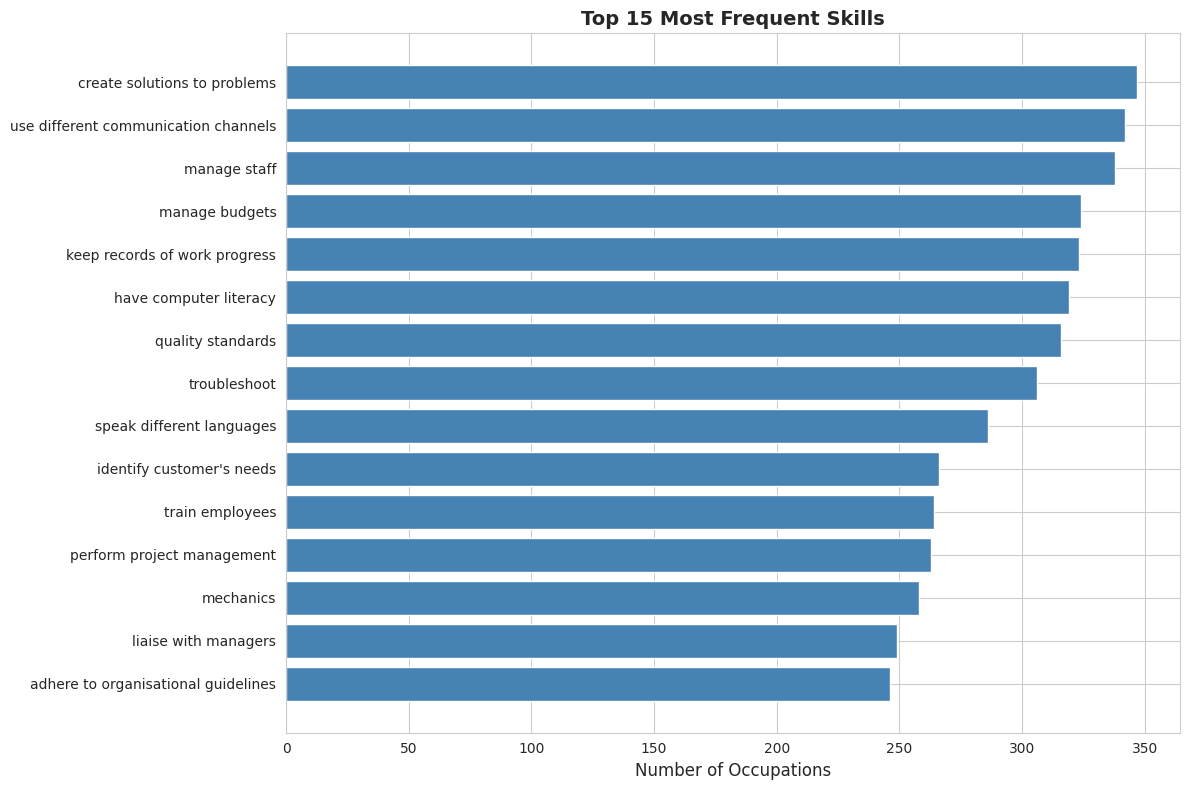

In [ ]:
print("MOST FREQUENT SKILLS AND PILLARS")
print("=" * 80)

# Most frequent skills across occupations
skill_frequency = occ_skills.groupby('skillUri').size().sort_values(ascending=False)

print(f"\nTop 15 Most Frequent Skills (across {total_occupations} occupations):")
print("-" * 80)

# Get skill names
top_skills = skill_frequency.head(15)
skill_details = []
for skill_uri, count in top_skills.items():
    skill_info = skills[skills['conceptUri'] == skill_uri]
    if not skill_info.empty:
        skill_name = skill_info.iloc[0]['preferredLabel']
        skill_type = skill_info.iloc[0].get('skillType', 'N/A')
        pct = (count / total_occupations) * 100
        skill_details.append({
            'Skill': skill_name,
            'Type': skill_type,
            'Occurrences': count,
            '% of Occupations': f'{pct:.1f}%'
        })

top_skills_df = pd.DataFrame(skill_details)
display(top_skills_df)

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_skills_df)), top_skills_df['Occurrences'], color='steelblue')
plt.yticks(range(len(top_skills_df)), top_skills_df['Skill'], fontsize=10)
plt.xlabel('Number of Occupations', fontsize=12)
plt.title('Top 15 Most Frequent Skills', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 5. Pillar Distribution Analysis


PILLAR DISTRIBUTION

Distribution across 4 main pillars:
--------------------------------------------------------------------------------


,Pillar,Skills Count,Percentage
0,skills,385,60.16
1,knowledge,221,34.53
2,transversal skills and competences,31,4.84
3,language skills and knowledge,3,0.47


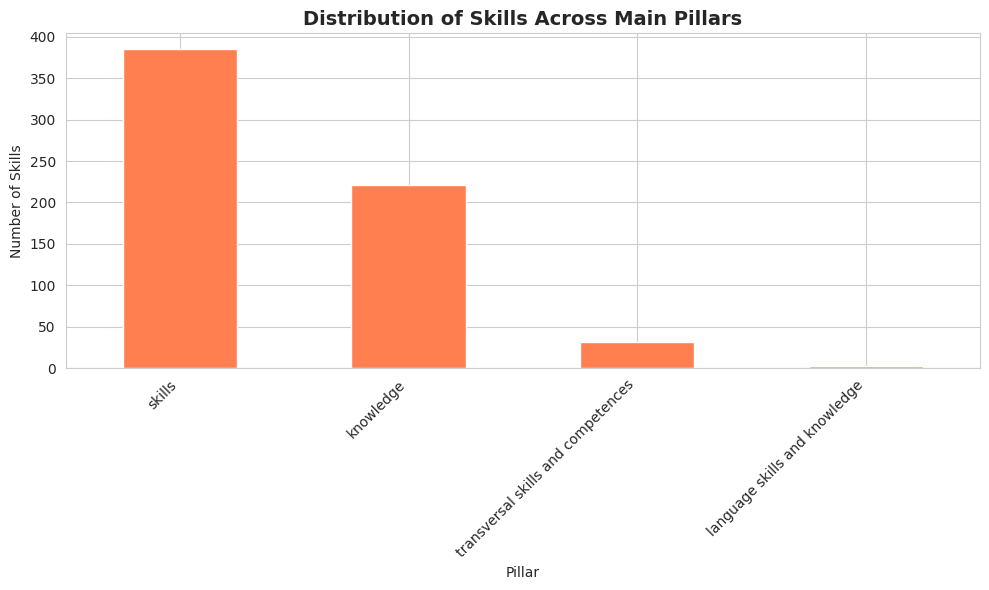

In [ ]:
print("PILLAR DISTRIBUTION")
print("=" * 80)

# Analyze pillars (Level 0)
if 'Level 0 preferred term' in skill_taxonomy.columns:
    pillar_counts = skill_taxonomy['Level 0 preferred term'].value_counts()
    
    print(f"\nDistribution across {len(pillar_counts)} main pillars:")
    print("-" * 80)
    
    pillar_df = pd.DataFrame({
        'Pillar': pillar_counts.index,
        'Skills Count': pillar_counts.values,
        'Percentage': (pillar_counts.values / len(skill_taxonomy) * 100).round(2)
    })
    display(pillar_df)
    
    # Visualize pillar distribution
    plt.figure(figsize=(10, 6))
    pillar_counts.plot(kind='bar', color='coral')
    plt.title('Distribution of Skills Across Main Pillars', fontsize=14, fontweight='bold')
    plt.xlabel('Pillar')
    plt.ylabel('Number of Skills')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nPillar information not directly available in hierarchy")


## 6. Skill Co-occurrence Network Analysis


In [ ]:
print("SKILL CO-OCCURRENCE GRAPH")
print("=" * 80)

# Build co-occurrence graph from skill-skill relations
print(f"\nBuilding skill co-occurrence network from {len(skill_skill_relations)} relations...")

# Create directed graph
G = nx.DiGraph()

# Add edges from skill-skill relations
for _, row in skill_skill_relations.iterrows():
    source = row['originalSkillUri']
    target = row['relatedSkillUri']
    rel_type = row['relationType']
    
    # Add edge with relationship type as attribute
    G.add_edge(source, target, relation_type=rel_type)

print(f"\n   • Total nodes (skills): {G.number_of_nodes()}")
print(f"   • Total edges (connections): {G.number_of_edges()}")
print(f"   • Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Analyze relation types
relation_types = skill_skill_relations['relationType'].value_counts()
print(f"\n   • Relation type distribution:")
for rel_type, count in relation_types.items():
    print(f"     - {rel_type}: {count} ({count/len(skill_skill_relations)*100:.1f}%)")

# Find most connected skills
degree_dict = dict(G.degree())
top_connected = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"\n   • Top 10 Most Connected Skills:")
for skill_uri, degree in top_connected:
    skill_info = skills[skills['conceptUri'] == skill_uri]
    if not skill_info.empty:
        skill_name = skill_info.iloc[0]['preferredLabel']
        print(f"     - {skill_name}: {degree} connections")


SKILL CO-OCCURRENCE GRAPH

Building skill co-occurrence network from 5818 relations...

   • Total nodes (skills): 5650
   • Total edges (connections): 5818
   • Average degree: 2.06

   • Relation type distribution:
     - optional: 5629 (96.8%)
     - essential: 189 (3.2%)

   • Top 10 Most Connected Skills:
     - musical instruments: 25 connections
     - risk management: 22 connections
     - identify support mechanisms to develop your professional practice: 20 connections
     - match needs of target community with your skills: 19 connections
     - accounting: 18 connections
     - nutrition: 17 connections
     - logistics: 17 connections
     - animal welfare legislation: 17 connections
     - variety of tobacco leaves: 16 connections
     - electronics: 16 connections



Visualizing skill co-occurrence network (top 30 most connected skills)...


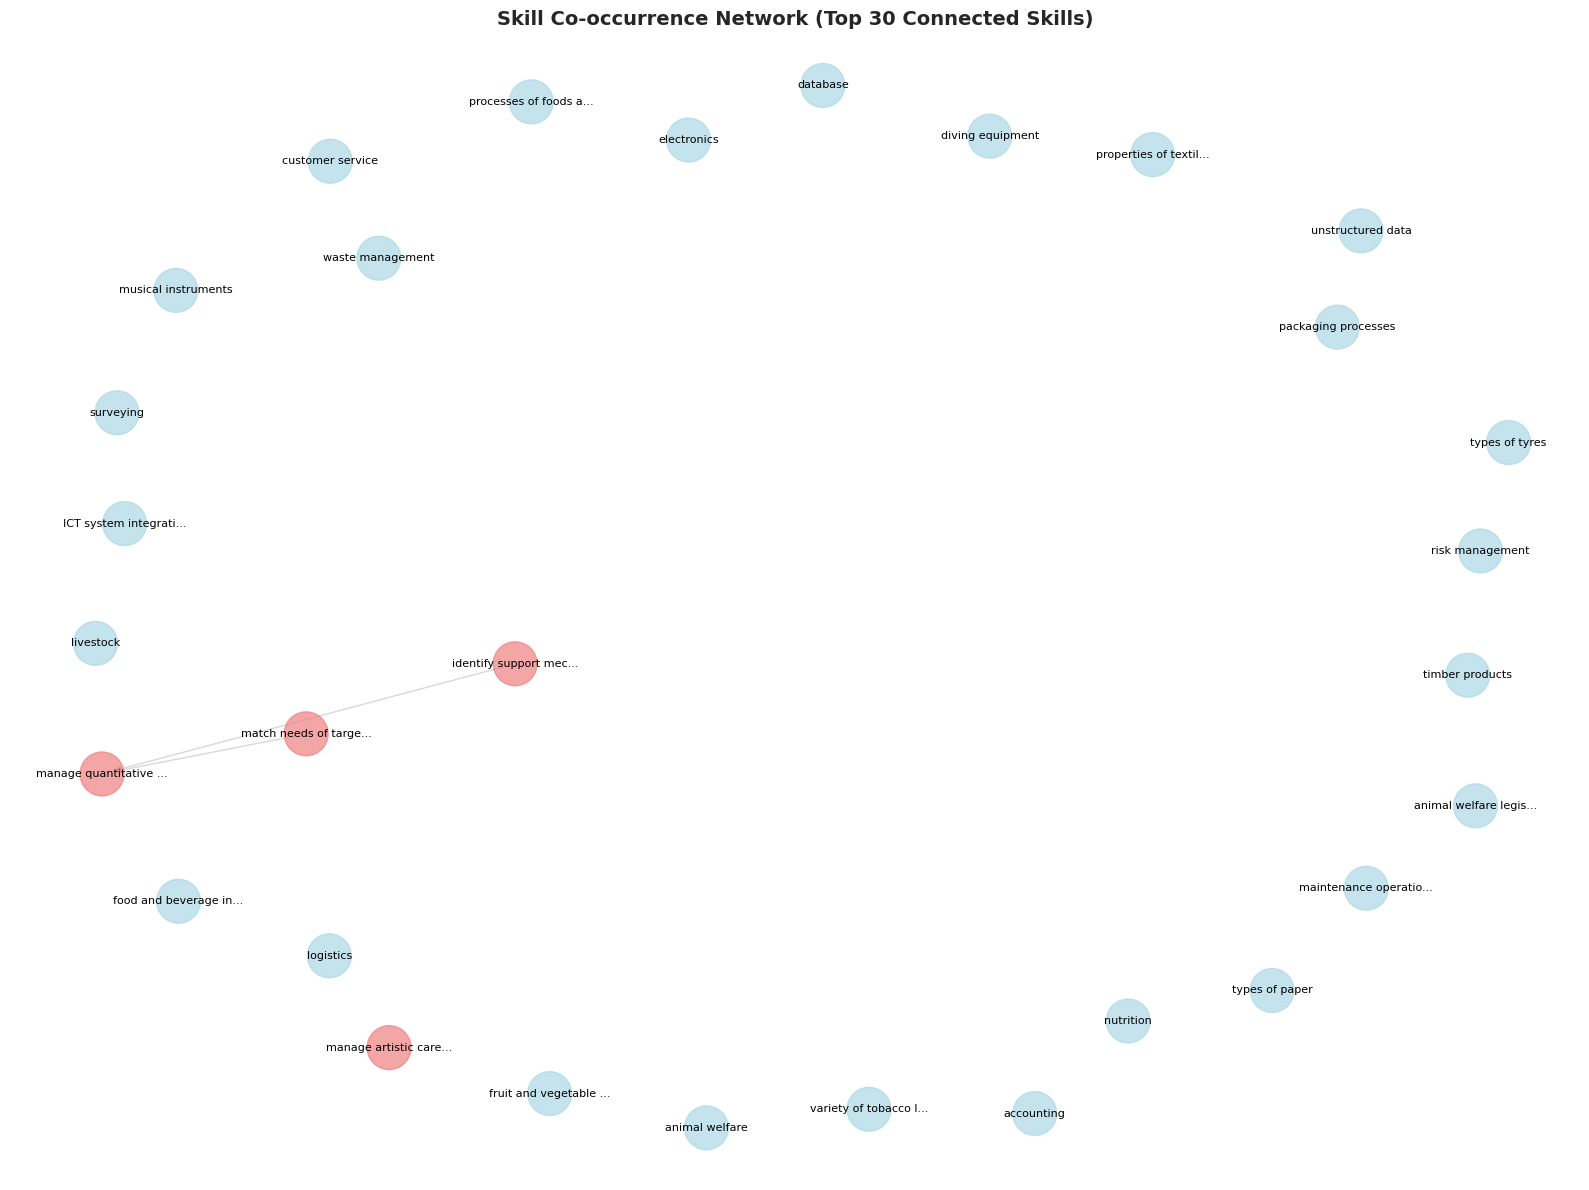


Subgraph statistics:
   • Nodes: 30
   • Edges: 2
   • Density: 0.0023


In [ ]:
# Visualize a subset of the graph (top connected skills)
print("\nVisualizing skill co-occurrence network (top 30 most connected skills)...")

# Get top 30 most connected nodes
top_30_nodes = [node for node, degree in sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:30]]

# Create subgraph
subgraph = G.subgraph(top_30_nodes)

# Create visualization
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

# Draw nodes
node_colors = []
for node in subgraph.nodes():
    skill_info = skills[skills['conceptUri'] == node]
    if not skill_info.empty and skill_info.iloc[0].get('skillType') == 'knowledge':
        node_colors.append('lightblue')
    else:
        node_colors.append('lightcoral')

nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, 
                       node_size=1000, alpha=0.7)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', 
                       alpha=0.3, arrows=True, arrowsize=10)

# Draw labels (abbreviated)
labels = {}
for node in subgraph.nodes():
    skill_info = skills[skills['conceptUri'] == node]
    if not skill_info.empty:
        full_name = skill_info.iloc[0]['preferredLabel']
        # Abbreviate long names
        labels[node] = full_name[:20] + '...' if len(full_name) > 20 else full_name

nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)

plt.title('Skill Co-occurrence Network (Top 30 Connected Skills)', 
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Network statistics
print(f"\nSubgraph statistics:")
print(f"   • Nodes: {subgraph.number_of_nodes()}")
print(f"   • Edges: {subgraph.number_of_edges()}")
print(f"   • Density: {nx.density(subgraph):.4f}")


## 7. Summary and Next Steps


In [ ]:
print("SUMMARY OF KEY FINDINGS")
print("=" * 80)

summary = f"""
KEY INSIGHTS FROM ESCO TAXONOMY ANALYSIS:

1. DATASET OVERVIEW
   - {total_skills:,} unique skills in the taxonomy
   - {total_occupations:,} distinct occupations
   - {total_relations:,} occupation-skill relationships
   - Average of {avg_skills_per_occ:.1f} skills per occupation

2. SKILL HIERARCHY
   - Multi-level taxonomy with clearly defined pillars
   - {len(skill_groups)} skill groups organizing the taxonomy
   - Hierarchical structure enables skill categorization and navigation

3. SKILL DISTRIBUTION
   - Most frequent skills appear in 10%+ of all occupations
   - Clear distinction between knowledge and competence/skill types
   - Strong clustering around certain skill domains

4. NETWORK STRUCTURE
   - Skill-skill relations show {G.number_of_nodes()} interconnected skills
   - Average of {sum(dict(G.degree()).values()) / G.number_of_nodes():.1f} connections per skill
   - Network reveals skill dependencies and relationships

5. NEXT STEPS FOR ANALYSIS
   - Deep dive into specific skill pillars or occupational families
   - Temporal analysis of skill evolution (if modification dates available)
   - Skill gap analysis between related occupations
   - Predictive modeling for skill demand forecasting
   - Text mining of skill descriptions for semantic relationships
"""

print(summary)


SUMMARY OF KEY FINDINGS

KEY INSIGHTS FROM ESCO TAXONOMY ANALYSIS:

1. DATASET OVERVIEW
   - 13,939 unique skills in the taxonomy
   - 3,039 distinct occupations
   - 129,004 occupation-skill relationships
   - Average of 42.4 skills per occupation

2. SKILL HIERARCHY
   - Multi-level taxonomy with clearly defined pillars
   - 640 skill groups organizing the taxonomy
   - Hierarchical structure enables skill categorization and navigation

3. SKILL DISTRIBUTION
   - Most frequent skills appear in 10%+ of all occupations
   - Clear distinction between knowledge and competence/skill types
   - Strong clustering around certain skill domains

4. NETWORK STRUCTURE
   - Skill-skill relations show 5650 interconnected skills
   - Average of 2.1 connections per skill
   - Network reveals skill dependencies and relationships

5. NEXT STEPS FOR ANALYSIS
   - Deep dive into specific skill pillars or occupational families
   - Temporal analysis of skill evolution (if modification dates available)
  

In [ ]:
print("OCCUPATION-SKILL RELATIONS DATASET")
print("=" * 80)
print(f"\nShape: {datasets['occupation_skill_relations'].shape}")
print(f"\nColumn Names and Types:")
print(datasets['occupation_skill_relations'].dtypes)
print(f"\nFirst few rows:")
display(datasets['occupation_skill_relations'].head(10))


OCCUPATION-SKILL RELATIONS DATASET

Shape: (129004, 4)

Column Names and Types:
occupationUri    object
relationType     object
skillType        object
skillUri         object
dtype: object

First few rows:


,occupationUri,relationType,skillType,skillUri
0,http://data.europa.eu/esco/occupation/00030d09...,essential,knowledge,http://data.europa.eu/esco/skill/fed5b267-73fa...
1,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/05bc7677-5a64...
2,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/271a36a0-bc7a...
3,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/47ed1d37-971b...
4,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/591dd514-735b...
5,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/860be36a-d19b...
6,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/892f8e2f-189a...
7,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/93a68dcb-3dc6...
8,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/f64fe2c2-d090...
9,http://data.europa.eu/esco/occupation/00030d09...,optional,skill/competence,http://data.europa.eu/esco/skill/a2dfc063-7b24...



Relation Type Distribution:


relationType
essential    67622
optional     61382
Name: count, dtype: int64

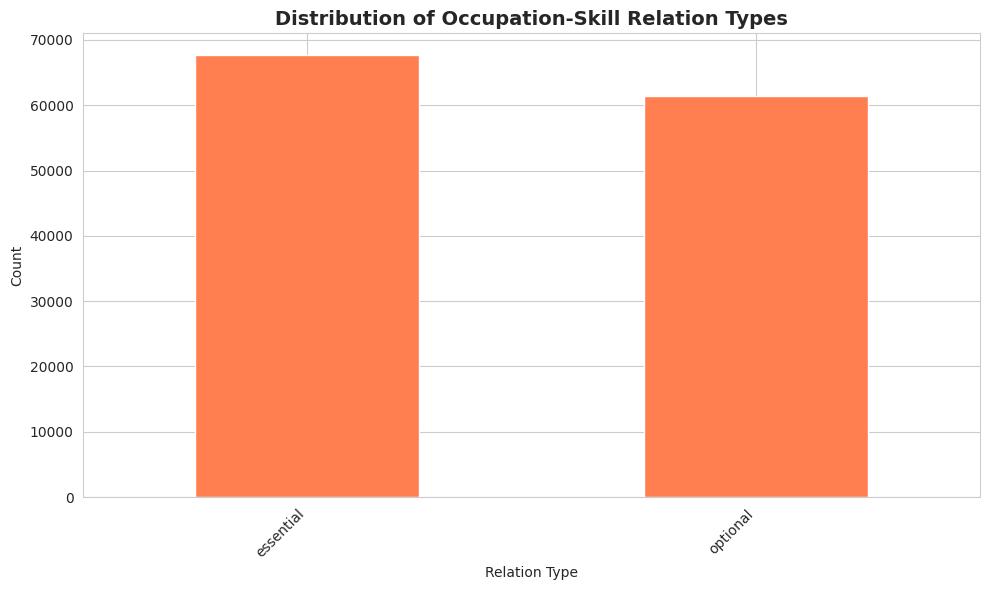


Skills per Occupation Statistics:
  Mean: 42.45
  Median: 37.00
  Min: 7
  Max: 345
  Std Dev: 25.76


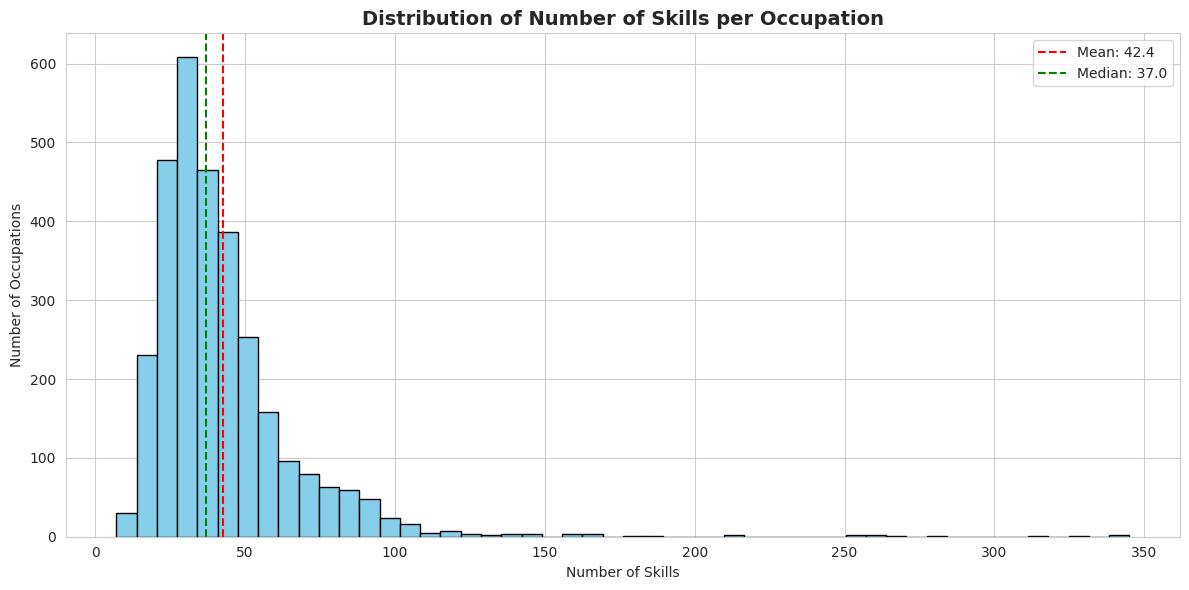


Top 10 Occupations by Number of Skills:


,Occupation URI,Number of Skills
0,http://data.europa.eu/esco/occupation/579254cf...,345
1,http://data.europa.eu/esco/occupation/547b304b...,339
2,http://data.europa.eu/esco/occupation/30f3ea93...,329
3,http://data.europa.eu/esco/occupation/d7d986e1...,314
4,http://data.europa.eu/esco/occupation/6426ada1...,279
5,http://data.europa.eu/esco/occupation/53d2052f...,270
6,http://data.europa.eu/esco/occupation/fde4372d...,261
7,http://data.europa.eu/esco/occupation/4b05bef2...,258
8,http://data.europa.eu/esco/occupation/86ca306c...,256
9,http://data.europa.eu/esco/occupation/b2cede50...,252


In [ ]:
# Analyze relation types if available
occ_skill_df = datasets['occupation_skill_relations']
if 'relationType' in occ_skill_df.columns:
    print("\nRelation Type Distribution:")
    relation_counts = occ_skill_df['relationType'].value_counts()
    display(relation_counts)
    
    # Visualize relation types
    plt.figure(figsize=(10, 6))
    relation_counts.plot(kind='bar', color='coral')
    plt.title('Distribution of Occupation-Skill Relation Types', fontsize=14, fontweight='bold')
    plt.xlabel('Relation Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Count skills per occupation
if 'occupationUri' in occ_skill_df.columns and 'skillUri' in occ_skill_df.columns:
    skills_per_occupation = occ_skill_df.groupby('occupationUri')['skillUri'].count()
    
    print(f"\nSkills per Occupation Statistics:")
    print(f"  Mean: {skills_per_occupation.mean():.2f}")
    print(f"  Median: {skills_per_occupation.median():.2f}")
    print(f"  Min: {skills_per_occupation.min()}")
    print(f"  Max: {skills_per_occupation.max()}")
    print(f"  Std Dev: {skills_per_occupation.std():.2f}")
    
    # Distribution plot
    plt.figure(figsize=(12, 6))
    plt.hist(skills_per_occupation, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Number of Skills per Occupation', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Skills')
    plt.ylabel('Number of Occupations')
    plt.axvline(skills_per_occupation.mean(), color='red', linestyle='--', label=f'Mean: {skills_per_occupation.mean():.1f}')
    plt.axvline(skills_per_occupation.median(), color='green', linestyle='--', label=f'Median: {skills_per_occupation.median():.1f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Top occupations by number of skills
    print("\nTop 10 Occupations by Number of Skills:")
    top_occupations = skills_per_occupation.nlargest(10)
    display(pd.DataFrame({'Occupation URI': top_occupations.index, 'Number of Skills': top_occupations.values}))



Occupations per Skill Statistics:
  Mean: 9.56
  Median: 4.00
  Min: 1
  Max: 347
  Std Dev: 20.09


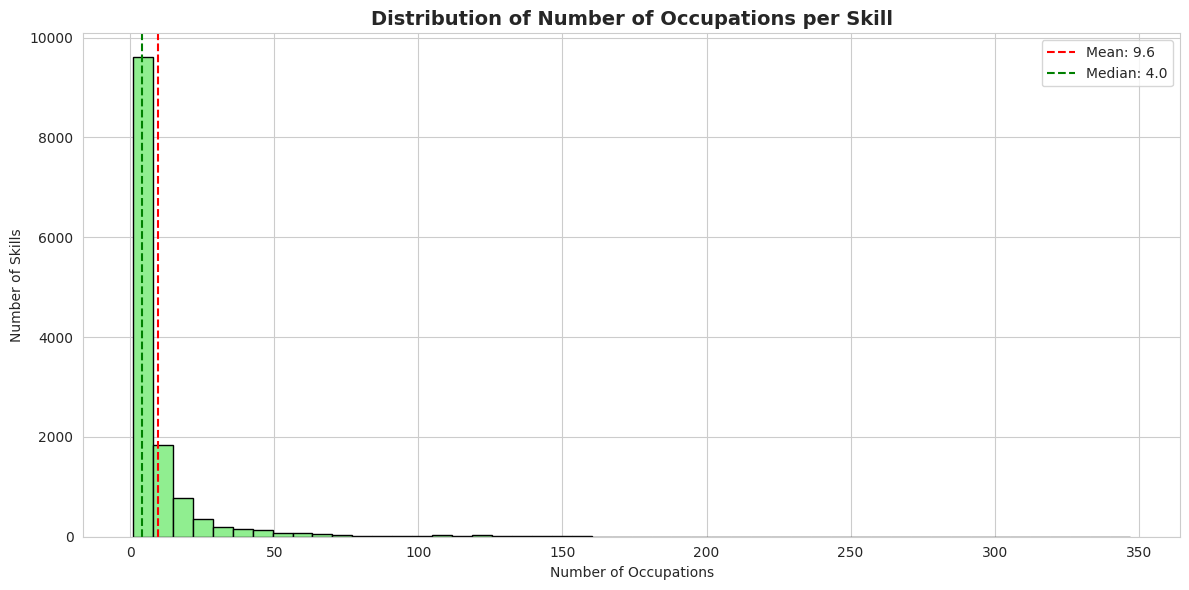


Top 10 Most Common Skills (across occupations):


,Skill URI,Number of Occupations
0,http://data.europa.eu/esco/skill/03b9b491-fc9b...,347
1,http://data.europa.eu/esco/skill/415abd43-e8e5...,342
2,http://data.europa.eu/esco/skill/339ac029-066a...,338
3,http://data.europa.eu/esco/skill/21c5790c-0930...,324
4,http://data.europa.eu/esco/skill/ccfbdaad-b91d...,323
5,http://data.europa.eu/esco/skill/d15ce60f-ddab...,319
6,http://data.europa.eu/esco/skill/8d4271ca-c9fd...,316
7,http://data.europa.eu/esco/skill/334e3e49-fb02...,306
8,http://data.europa.eu/esco/skill/2de4572a-4724...,286
9,http://data.europa.eu/esco/skill/68698869-c13c...,266


In [ ]:
# Count occupations per skill
if 'occupationUri' in occ_skill_df.columns and 'skillUri' in occ_skill_df.columns:
    occupations_per_skill = occ_skill_df.groupby('skillUri')['occupationUri'].count()
    
    print(f"\nOccupations per Skill Statistics:")
    print(f"  Mean: {occupations_per_skill.mean():.2f}")
    print(f"  Median: {occupations_per_skill.median():.2f}")
    print(f"  Min: {occupations_per_skill.min()}")
    print(f"  Max: {occupations_per_skill.max()}")
    print(f"  Std Dev: {occupations_per_skill.std():.2f}")
    
    # Distribution plot
    plt.figure(figsize=(12, 6))
    plt.hist(occupations_per_skill, bins=50, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Number of Occupations per Skill', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Occupations')
    plt.ylabel('Number of Skills')
    plt.axvline(occupations_per_skill.mean(), color='red', linestyle='--', label=f'Mean: {occupations_per_skill.mean():.1f}')
    plt.axvline(occupations_per_skill.median(), color='green', linestyle='--', label=f'Median: {occupations_per_skill.median():.1f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Most common skills
    print("\nTop 10 Most Common Skills (across occupations):")
    top_skills = occupations_per_skill.nlargest(10)
    display(pd.DataFrame({'Skill URI': top_skills.index, 'Number of Occupations': top_skills.values}))


## 7. Skills Hierarchy Analysis


In [ ]:
print("SKILLS HIERARCHY DATASET")
print("=" * 80)
print(f"\nShape: {datasets['skills_hierarchy'].shape}")
print(f"\nColumn Names and Types:")
print(datasets['skills_hierarchy'].dtypes)
print(f"\nFirst few rows:")
display(datasets['skills_hierarchy'].head(10))

# Analyze hierarchy depth
hierarchy_df = datasets['skills_hierarchy']
if 'broaderUri' in hierarchy_df.columns and 'conceptUri' in hierarchy_df.columns:
    # Count parent-child relationships
    children_per_parent = hierarchy_df.groupby('broaderUri')['conceptUri'].count()
    
    print(f"\nChildren per Parent Node Statistics:")
    print(f"  Mean: {children_per_parent.mean():.2f}")
    print(f"  Median: {children_per_parent.median():.2f}")
    print(f"  Min: {children_per_parent.min()}")
    print(f"  Max: {children_per_parent.max()}")
    
    # Root nodes (nodes that appear as children but not as parents)
    all_children = set(hierarchy_df['conceptUri'].unique())
    all_parents = set(hierarchy_df['broaderUri'].unique())
    root_nodes = all_parents - all_children
    leaf_nodes = all_children - all_parents
    
    print(f"\nHierarchy Structure:")
    print(f"  Root nodes (top-level): {len(root_nodes)}")
    print(f"  Leaf nodes (bottom-level): {len(leaf_nodes)}")
    print(f"  Intermediate nodes: {len(all_children & all_parents)}")


SKILLS HIERARCHY DATASET

Shape: (640, 14)

Column Names and Types:
Level 0 URI               object
Level 0 preferred term    object
Level 1 URI               object
Level 1 preferred term    object
Level 2 URI               object
Level 2 preferred term    object
Level 3 URI               object
Level 3 preferred term    object
Description               object
Scope note                object
Level 0 code              object
Level 1 code              object
Level 2 code              object
Level 3 code              object
dtype: object

First few rows:


,Level 0 URI,Level 0 preferred term,Level 1 URI,Level 1 preferred term,Level 2 URI,Level 2 preferred term,Level 3 URI,Level 3 preferred term,Description,Scope note,Level 0 code,Level 1 code,Level 2 code,Level 3 code
0,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,NaN,NaN,NaN
1,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,http://data.europa.eu/esco/skill/43f425aa-f45d...,languages,NaN,NaN,NaN,NaN,"Ability to communicate through reading, writin...",NaN,L,L1,NaN,NaN
2,http://data.europa.eu/esco/skill/e35a5936-091d...,language skills and knowledge,http://data.europa.eu/esco/skill/e434e71a-f068...,classical languages,NaN,NaN,NaN,NaN,"All dead languages, no longer actively used, o...",Excludes:\n- all languages that are actively ...,L,L2,NaN,NaN
3,http://data.europa.eu/esco/skill/335228d2-297d...,skills,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN
4,http://data.europa.eu/esco/skill/335228d2-297d...,skills,http://data.europa.eu/esco/skill/03e0b95b-67d1...,handling and moving,NaN,NaN,NaN,NaN,"Sorting, arranging, moving, transforming, fabr...",Excludes:\n- Specific skills involving interac...,S,S6,NaN,NaN
5,http://data.europa.eu/esco/skill/335228d2-297d...,skills,http://data.europa.eu/esco/skill/03e0b95b-67d1...,handling and moving,http://data.europa.eu/esco/skill/15dfca7a-5dde...,handling and disposing of waste and hazardous ...,NaN,NaN,"Collecting, storing and disposing of unwanted ...",NaN,S,S6,S6.13,NaN
6,http://data.europa.eu/esco/skill/335228d2-297d...,skills,http://data.europa.eu/esco/skill/03e0b95b-67d1...,handling and moving,http://data.europa.eu/esco/skill/15dfca7a-5dde...,handling and disposing of waste and hazardous ...,http://data.europa.eu/esco/skill/61d1dab2-6007...,disposing of non-hazardous waste or debris,Collecting and disposing of unwanted non-hazar...,Examples:\n- Handle fish harvesting waste \n- ...,S,S6,S6.13,S6.13.2
7,http://data.europa.eu/esco/skill/335228d2-297d...,skills,http://data.europa.eu/esco/skill/03e0b95b-67d1...,handling and moving,http://data.europa.eu/esco/skill/15dfca7a-5dde...,handling and disposing of waste and hazardous ...,http://data.europa.eu/esco/skill/8bde58aa-9d5b...,handling and disposing of hazardous materials,"Handling, collecting, storing and disposing of...",Hazardous waste is defined in accordance with ...,S,S6,S6.13,S6.13.1
8,http://data.europa.eu/esco/skill/335228d2-297d...,skills,http://data.europa.eu/esco/skill/03e0b95b-67d1...,handling and moving,http://data.europa.eu/esco/skill/15dfca7a-5dde...,handling and disposing of waste and hazardous ...,http://data.europa.eu/esco/skill/f8c676de-c871...,handling and disposing of waste and hazardous ...,"Collecting, storing and disposing of unwanted ...",NaN,S,S6,S6.13,S6.13.0
9,http://data.europa.eu/esco/skill/335228d2-297d...,skills,http://data.europa.eu/esco/skill/03e0b95b-67d1...,handling and moving,http://data.europa.eu/esco/skill/1cc5ff0b-afaa...,moving and lifting,NaN,NaN,"Performing physical activities to move, load, ...",Excludes:\n- Specific skills involving lifting...,S,S6,S6.2,NaN


## 8. Skill-Skill Relations Analysis


SKILL-SKILL RELATIONS DATASET

Shape: (5818, 5)

Column Names and Types:
originalSkillUri     object
originalSkillType    object
relationType         object
relatedSkillType     object
relatedSkillUri      object
dtype: object

First few rows:


,originalSkillUri,originalSkillType,relationType,relatedSkillType,relatedSkillUri
0,http://data.europa.eu/esco/skill/00064735-8fad...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/d4a0744a-508b...
1,http://data.europa.eu/esco/skill/000bb1e4-89f0...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/b70ab677-5781...
2,http://data.europa.eu/esco/skill/0023e7a5-43da...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/5753e2ca-8934...
3,http://data.europa.eu/esco/skill/00298d97-3dc3...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/1ff53c92-370d...
4,http://data.europa.eu/esco/skill/008a0e0d-7380...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/af0bbc31-b54d...
5,http://data.europa.eu/esco/skill/009673d9-e2fd...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/3fa0a100-66ea...
6,http://data.europa.eu/esco/skill/009673d9-e2fd...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/bb992d83-2d7d...
7,http://data.europa.eu/esco/skill/009673d9-e2fd...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/c197585c-4e3b...
8,http://data.europa.eu/esco/skill/009673d9-e2fd...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/d11fd23b-ad01...
9,http://data.europa.eu/esco/skill/009db49b-fcf5...,knowledge,optional,knowledge,http://data.europa.eu/esco/skill/e126f782-b4e6...



Skill-Skill Relation Type Distribution:


relationType
optional     5629
essential     189
Name: count, dtype: int64

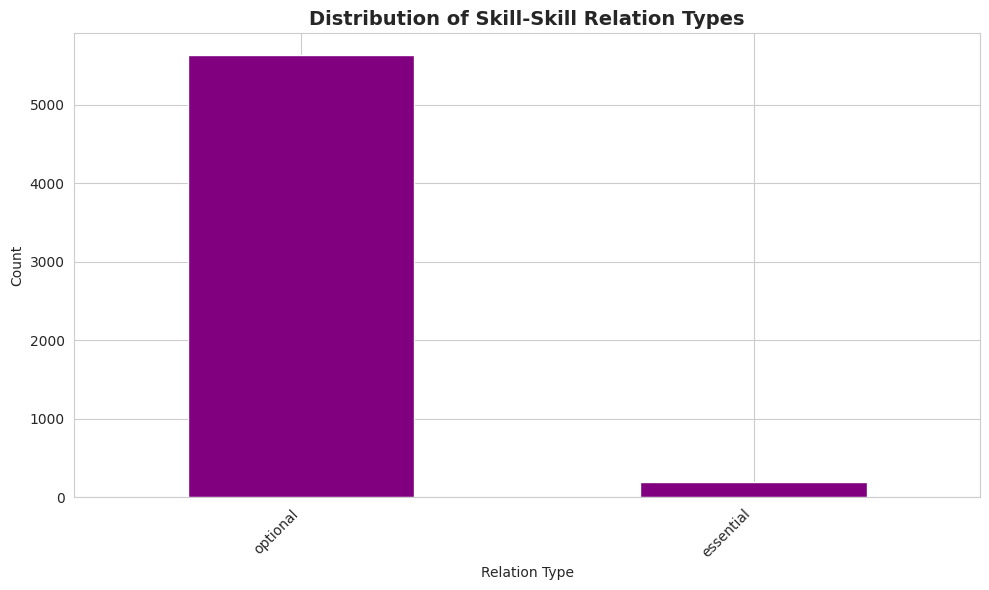

In [ ]:
print("SKILL-SKILL RELATIONS DATASET")
print("=" * 80)
print(f"\nShape: {datasets['skill_skill_relations'].shape}")
print(f"\nColumn Names and Types:")
print(datasets['skill_skill_relations'].dtypes)
print(f"\nFirst few rows:")
display(datasets['skill_skill_relations'].head(10))

skill_skill_df = datasets['skill_skill_relations']
if 'relationType' in skill_skill_df.columns:
    print("\nSkill-Skill Relation Type Distribution:")
    ss_relation_counts = skill_skill_df['relationType'].value_counts()
    display(ss_relation_counts)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    ss_relation_counts.plot(kind='bar', color='purple')
    plt.title('Distribution of Skill-Skill Relation Types', fontsize=14, fontweight='bold')
    plt.xlabel('Relation Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## 9. Research Collections Analysis


In [ ]:
print("RESEARCH SKILLS COLLECTION")
print("=" * 80)
print(f"Shape: {datasets['research_skills'].shape}")
display(datasets['research_skills'].head())

print("\n" + "=" * 80)
print("RESEARCH OCCUPATIONS COLLECTION")
print("=" * 80)
print(f"Shape: {datasets['research_occupations'].shape}")
display(datasets['research_occupations'].head())


RESEARCH SKILLS COLLECTION
Shape: (40, 10)


,conceptType,conceptUri,preferredLabel,status,skillType,reuseLevel,altLabels,description,broaderConceptUri,broaderConceptPT
0,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00b9a3aa-7070...,draft scientific or academic papers and techni...,released,skill/competence,cross-sector,write scientific and academic papers | write t...,"Draft and edit scientific, academic or technic...",http://data.europa.eu/esco/skill/6e62e776-fbfa...,technical or academic writing
1,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/08b04e53-ed25...,manage research data,released,skill/competence,cross-sector,administer research data | handle research dat...,Produce and analyse scientific data originatin...,http://data.europa.eu/esco/skill/32c017fd-28ab...,managing information
2,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/20a8fe89-d4eb...,interact professionally in research and profes...,released,skill/competence,cross-sector,interact appropriately in research and profess...,Show consideration to others as well as colleg...,http://data.europa.eu/esco/skill/91b0b918-942e...,working with others
3,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/2b1e2927-3542...,disseminate results to the scientific community,released,skill/competence,cross-sector,disseminate results of scientific research | d...,Publicly disclose scientific results by any ap...,http://data.europa.eu/esco/skill/6e62e776-fbfa...,technical or academic writing
4,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/2b34764d-637c...,operate open source software,released,skill/competence,sector-specific,manage open-source software | know open-source...,"Operate Open Source software, knowing the main...",http://data.europa.eu/esco/skill/a8c3186b-c791...,programming computer systems



RESEARCH OCCUPATIONS COLLECTION
Shape: (122, 8)


,conceptType,conceptUri,preferredLabel,status,altLabels,description,broaderConceptUri,broaderConceptPT
0,Occupation,http://data.europa.eu/esco/occupation/01ffb917...,biomedical engineer,released,BME consultant | bio-medical engineer | biomed...,Biomedical engineers combine knowledge of engi...,http://data.europa.eu/esco/occupation/f9433fdb...,bioengineer
1,Occupation,http://data.europa.eu/esco/occupation/0611f232...,criminologist,released,criminology science researcher | criminology s...,Criminologists study conditions pertaining to ...,http://data.europa.eu/esco/isco/C2632,"Sociologists, anthropologists and related prof..."
2,Occupation,http://data.europa.eu/esco/occupation/0959cd1d...,economics lecturer,released,economics teacher | university economics lectu...,"Economics lecturers are subject professors, as...",http://data.europa.eu/esco/occupation/684fd8d5...,higher education lecturer
3,Occupation,http://data.europa.eu/esco/occupation/0bf5d25a...,medicine lecturer,released,clinical lecturer | university lecturer in med...,"Medicine lecturers are subject professors, tea...",http://data.europa.eu/esco/occupation/684fd8d5...,higher education lecturer
4,Occupation,http://data.europa.eu/esco/occupation/0c7c9606...,medical device engineer,released,engineer in biomedical systems | engineer of m...,Medical device engineers design and develop me...,http://data.europa.eu/esco/occupation/4d34a9ee...,electronics engineer


## 10. Data Quality Checks


In [37]:
print("DATA QUALITY CHECKS")
print("=" * 80)

# Check for duplicates in each dataset
print("\nDuplicate Rows:")
for name, df in datasets.items():
    duplicates = df.duplicated().sum()
    print(f"  {name}: {duplicates} duplicate rows ({duplicates/len(df)*100:.2f}%)")

# Check for null values summary
print("\n\nNull Values Summary:")
for name, df in datasets.items():
    null_count = df.isnull().sum().sum()
    total_cells = df.shape[0] * df.shape[1]
    print(f"  {name}: {null_count} null values ({null_count/total_cells*100:.2f}% of all cells)")


DATA QUALITY CHECKS

Duplicate Rows:
  skills: 0 duplicate rows (0.00%)
  skill_groups: 0 duplicate rows (0.00%)
  skills_hierarchy: 0 duplicate rows (0.00%)
  skill_skill_relations: 0 duplicate rows (0.00%)
  occupations: 0 duplicate rows (0.00%)
  occupation_skill_relations: 0 duplicate rows (0.00%)
  research_skills: 0 duplicate rows (0.00%)
  research_occupations: 0 duplicate rows (0.00%)


Null Values Summary:
  skills: 41785 null values (23.06% of all cells)
  skill_groups: 1899 null values (26.97% of all cells)
  skills_hierarchy: 1121 null values (12.51% of all cells)
  skill_skill_relations: 0 null values (0.00% of all cells)
  occupations: 8822 null values (20.74% of all cells)
  occupation_skill_relations: 59 null values (0.01% of all cells)
  research_skills: 0 null values (0.00% of all cells)
  research_occupations: 1 null values (0.10% of all cells)


## 11. Cross-Dataset Consistency Checks


In [ ]:
print("CROSS-DATASET CONSISTENCY CHECKS")
print("=" * 80)

# Check if all skills in occupation-skill relations exist in skills dataset
if 'conceptUri' in datasets['skills'].columns and 'skillUri' in datasets['occupation_skill_relations'].columns:
    skills_in_main = set(datasets['skills']['conceptUri'].unique())
    skills_in_relations = set(datasets['occupation_skill_relations']['skillUri'].unique())
    
    skills_not_in_main = skills_in_relations - skills_in_main
    print(f"\nSkills in occupation-skill relations: {len(skills_in_relations)}")
    print(f"Skills in main skills dataset: {len(skills_in_main)}")
    print(f"Skills in relations but not in main dataset: {len(skills_not_in_main)}")
    
    if len(skills_not_in_main) > 0:
        print(f"  Warning: {len(skills_not_in_main)} skills referenced in relations are not in the main skills dataset")

# Check if all occupations in relations exist in occupations dataset
if 'conceptUri' in datasets['occupations'].columns and 'occupationUri' in datasets['occupation_skill_relations'].columns:
    occupations_in_main = set(datasets['occupations']['conceptUri'].unique())
    occupations_in_relations = set(datasets['occupation_skill_relations']['occupationUri'].unique())
    
    occupations_not_in_main = occupations_in_relations - occupations_in_main
    print(f"\nOccupations in occupation-skill relations: {len(occupations_in_relations)}")
    print(f"Occupations in main occupations dataset: {len(occupations_in_main)}")
    print(f"Occupations in relations but not in main dataset: {len(occupations_not_in_main)}")
    
    if len(occupations_not_in_main) > 0:
        print(f"  Warning: {len(occupations_not_in_main)} occupations referenced in relations are not in the main occupations dataset")


CROSS-DATASET CONSISTENCY CHECKS

Skills in occupation-skill relations: 13492
Skills in main skills dataset: 13939
Skills in relations but not in main dataset: 0

Occupations in occupation-skill relations: 3039
Occupations in main occupations dataset: 3039
Occupations in relations but not in main dataset: 0


## 12. Summary and Key Insights


In [ ]:
print("ESCO DATASET SUMMARY")
print("=" * 80)

summary_text = f"""
Key Findings:

1. Dataset Sizes:
   - Skills: {datasets['skills'].shape[0]:,} records
   - Skill Groups: {datasets['skill_groups'].shape[0]:,} records
   - Occupations: {datasets['occupations'].shape[0]:,} records
   - Occupation-Skill Relations: {datasets['occupation_skill_relations'].shape[0]:,} records
   - Skills Hierarchy: {datasets['skills_hierarchy'].shape[0]:,} records
   - Skill-Skill Relations: {datasets['skill_skill_relations'].shape[0]:,} records

2. Relationships:
   - The occupation-skill relations dataset is the largest, indicating rich connections
     between occupations and skills
   - Average skills per occupation and occupations per skill provide insights into 
     the complexity of the job market
   
3. Data Quality:
   - Check duplicate and null value statistics above
   - Cross-dataset consistency should be validated for any analysis

4. Next Steps:
   - Deep dive into specific skill categories or occupation groups
   - Network analysis of skill-skill and occupation-skill relationships
   - Text analysis of skill and occupation descriptions
   - Temporal analysis if date information is available
"""

print(summary_text)


ESCO DATASET SUMMARY

Key Findings:

1. Dataset Sizes:
   - Skills: 13,939 records
   - Skill Groups: 640 records
   - Occupations: 3,039 records
   - Occupation-Skill Relations: 129,004 records
   - Skills Hierarchy: 640 records
   - Skill-Skill Relations: 5,818 records

2. Relationships:
   - The occupation-skill relations dataset is the largest, indicating rich connections
     between occupations and skills
   - Average skills per occupation and occupations per skill provide insights into 
     the complexity of the job market

3. Data Quality:
   - Check duplicate and null value statistics above
   - Cross-dataset consistency should be validated for any analysis

4. Next Steps:
   - Deep dive into specific skill categories or occupation groups
   - Network analysis of skill-skill and occupation-skill relationships
   - Text analysis of skill and occupation descriptions
   - Temporal analysis if date information is available

